In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import json
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.utils import mask_to_categorical
from stardist.plot import render_label

import matplotlib.colors as mcolors
import copy

np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab20


def cus_plot_img_label(X_main, lbl, cls_dict):
    X_modified = X_main.copy()  # Create a copy of the input image

    c = mask_to_categorical(lbl, n_classes=4, classes=cls_dict)
    res = np.argmax(c, axis=-1).astype(np.uint16)

    colors = {
        1: (59 / 255, 154 / 255, 251 / 255),   # Blue for mask value 1
        2: (0 / 255, 255 / 255, 61 / 255),     # Green for mask value 2
        3: (250 / 255, 220 / 255, 57 / 255),   # Yellow for mask value 3
        4: (255 / 255, 0 / 255, 23 / 255)      # Red for mask value 4
    }

    h, w = res.shape[:2]
    mask_values = np.unique(res)

    for mask_value in mask_values:
        if mask_value in colors:
            color = colors[mask_value]
            mask = res == mask_value
            X_modified[mask] = color

    return X_modified


def plot_all(img, lbl, cls_dict, img_title="ROI", lbl_title="Ground truth", cls_title="Ground truth by Classs", font_size=18, **kwargs):
    
    plot_img=cus_plot_img_label(img,lbl,cls_dict)
    
    
    fig, (ai,al,ac) = plt.subplots(1,3, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title, fontsize=font_size)    
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title, fontsize=font_size)
    ac.imshow(plot_img)
    ac.set_title(cls_title, fontsize=font_size)
    plt.tight_layout()    
    for a in ai,al,ac:
        a.axis("off")
    return ai,al,ac

C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
transport.py (219): Blowfish has been deprecated


In [2]:
# set the number of object classes
n_classes = 4

In [3]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm import tqdm

def make_image(folder_paths, height, width):
    
    new_image = np.zeros((height, width), dtype=np.uint8)
    
    my_dict = {}

    class_name_reco = {
        'Blue': 1,
        'Green': 2,
        'Yellow': 3,
        'Red': 4
    }
    for i, path in enumerate(folder_paths):
        
        class_name= path.split('\\')[-1].split('_')[-2]
        reference_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        reference_image = cv2.resize(reference_image, (width, height))
        new_image[reference_image > 0 ] = i+1
        my_dict[i+1] = class_name_reco[class_name]
        
        
    return new_image, my_dict


    
X_test=[]
Y_test=[]
C_test=[]
for path in tqdm(os.listdir(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing')):
    roi=io.imread(glob.glob(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing/'+path+'/image/*.png')[0])
    height, width, _ = roi.shape
    #height, width, _ = [256,256,3]
    roi = transform.resize(roi, (height, width))
    
    folder_paths= glob.glob(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing/'+path+'/color_masks/*.png')
    one_image, my_dict=make_image(folder_paths, height, width)
    
    X_test.append(roi)
    Y_test.append(one_image)
    C_test.append(my_dict)

100%|██████████| 44/44 [00:07<00:00,  5.93it/s]


(<Axes: title={'center': 'ROI'}>,
 <Axes: title={'center': 'Ground truth'}>,
 <Axes: title={'center': 'Ground truth by Classs'}>)

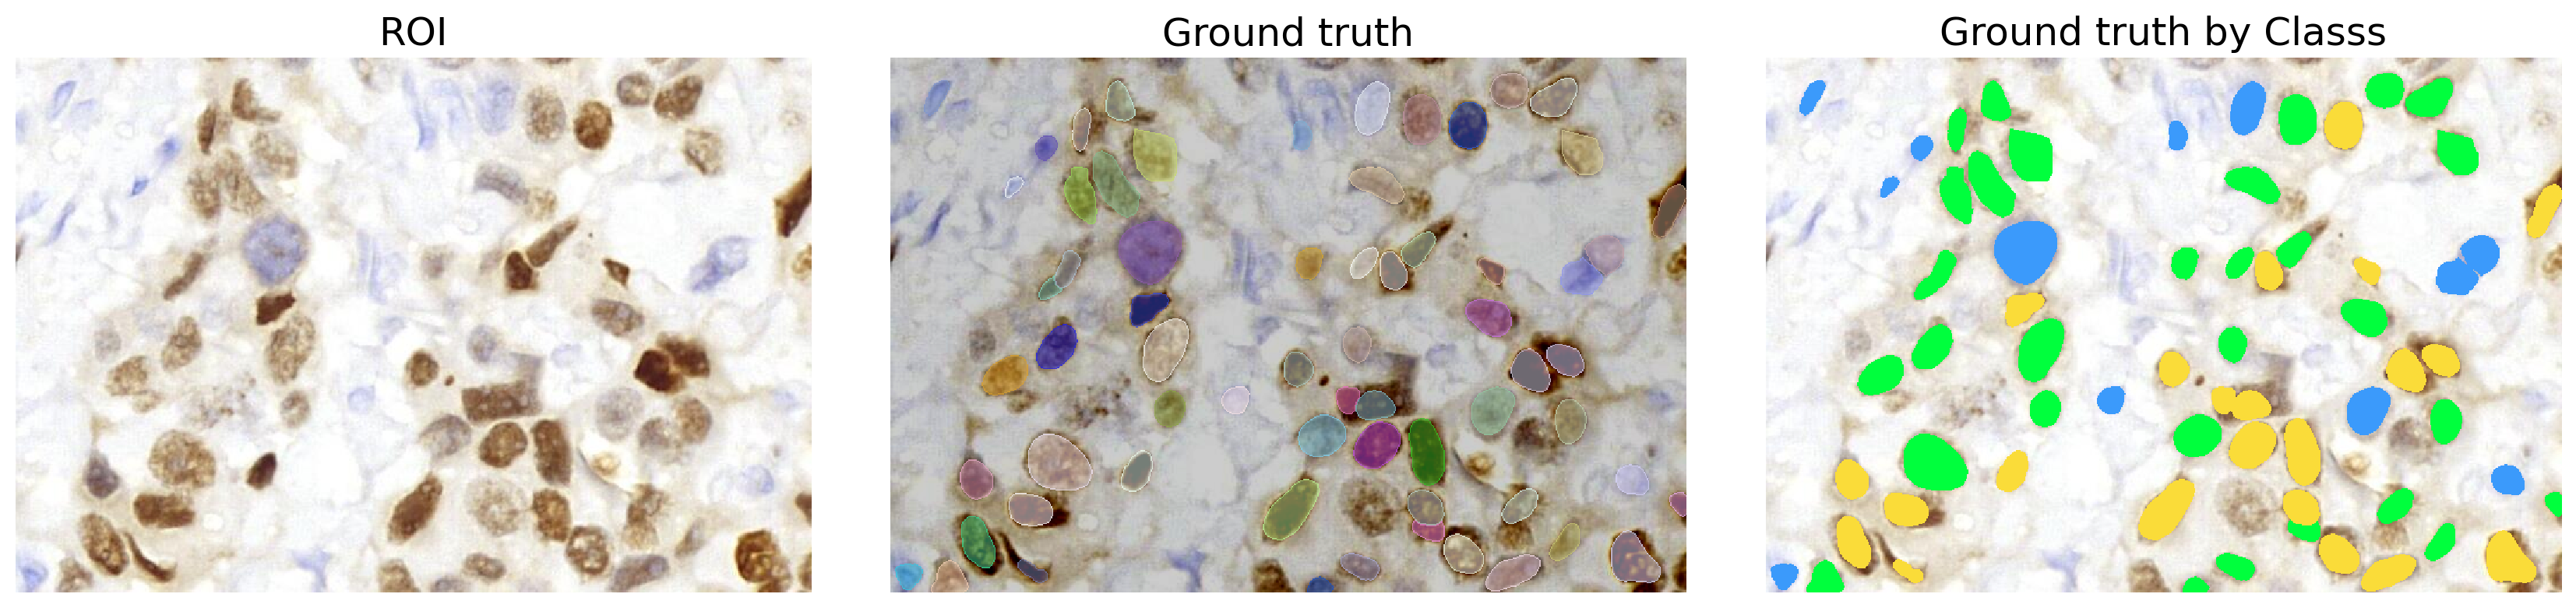

In [4]:
valuesss=24
plot_all(X_test[valuesss],Y_test[valuesss], C_test[valuesss])

In [5]:
model = StarDist2D(None, name='resnet50unet_multiclass_ai4dp_none', basedir='models')

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   896         ['input[0][0]']                  
                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   9248        ['conv2d[0][0]']                 
                                32)                                                        

                                                                                                  
 conv2_block2_2_relu (Activatio  (None, None, None,   0          ['conv2_block2_2_bn[0][0]']      
 n)                             64)                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, None, None,   16640       ['conv2_block2_2_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, None, None,   1024       ['conv2_block2_3_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, None, None,   0          ['conv3_block2_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, None, None,   147584      ['conv3_block2_1_relu[0][0]']    
                                128)                                                              
          

 conv3_block4_add (Add)         (None, None, None,   0           ['conv3_block3_out[0][0]',       
                                512)                              'conv3_block4_3_bn[0][0]']      
                                                                                                  
 conv3_block4_out (Activation)  (None, None, None,   0           ['conv3_block4_add[0][0]']       
                                512)                                                              
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, None, None,   131328      ['conv3_block4_out[0][0]']       
                                256)                                                              
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block3_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, None, None,   0          ['conv4_block3_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block3_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, None, None,   0          ['conv4_block6_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block6_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block6_2_conv[0][0]']    
 ization)                       256)                                                              
          

 conv5_block2_3_bn (BatchNormal  (None, None, None,   8192       ['conv5_block2_3_conv[0][0]']    
 ization)                       2048)                                                             
                                                                                                  
 conv5_block2_add (Add)         (None, None, None,   0           ['conv5_block1_out[0][0]',       
                                2048)                             'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, None, None,   0           ['conv5_block2_add[0][0]']       
                                2048)                                                             
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
          

                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, None, None,   36928       ['conv2_block1_1_relu[0][0]']    
                                64)                                                               
                                                                                                  
 conv2_block1_2_bn (BatchNormal  (None, None, None,   256        ['conv2_block1_2_conv[0][0]']    
 ization)                       64)                                                               
                                                                                                  
 conv2_block1_2_relu (Activatio  (None, None, None,   0          ['conv2_block1_2_bn[0][0]']      
 n)                             64)                                                               
                                                                                                  
 conv2_blo

                                256)                              'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_block3_out (Activation)  (None, None, None,   0           ['conv2_block3_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, None, None,   32896       ['conv2_block3_out[0][0]']       
                                128)                                                              
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block1_1_conv[0][0]']    
 ization)                       128)                                                              
          

 conv3_block3_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block3_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, None, None,   0          ['conv3_block3_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block3_2_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, None, None,   2048       ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 up_level_0_no_2 (Conv2D)       (None, None, None,   9248        ['up_level_0_no_0[0][0]']        
                                32)                                                               
                                                                                                  
 features (Conv2D)              (None, None, None,   36992       ['up_level_0_no_2[0][0]']        
                                128)                                                              
                                                                                                  
 features_class (Conv2D)        (None, None, None,   36992       ['up_level_0_no_2[0][0]']        
                                128)                                                              
                                                                                                  
 prob (Con

In [6]:
# model.optimize_thresholds(X_test, Y_test)

In [7]:
i = 42
label, res = model.predict_instances(X_test[i], n_tiles=model._guess_n_tiles(X_test[i]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 26ms/step



  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



 50%|█████     | 1/2 [00:01<00:01,  1.62s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


In [8]:
# the class object ids are stored in the 'results' dict and correspond to the label ids in increasing order 
def class_from_res(res):
    cls_dict = dict((i+1,c) for i,c in enumerate(res['class_id']))
    return cls_dict


(<Axes: title={'center': 'ROI'}>,
 <Axes: title={'center': 'Predict'}>,
 <Axes: title={'center': 'Predict by Classs'}>)

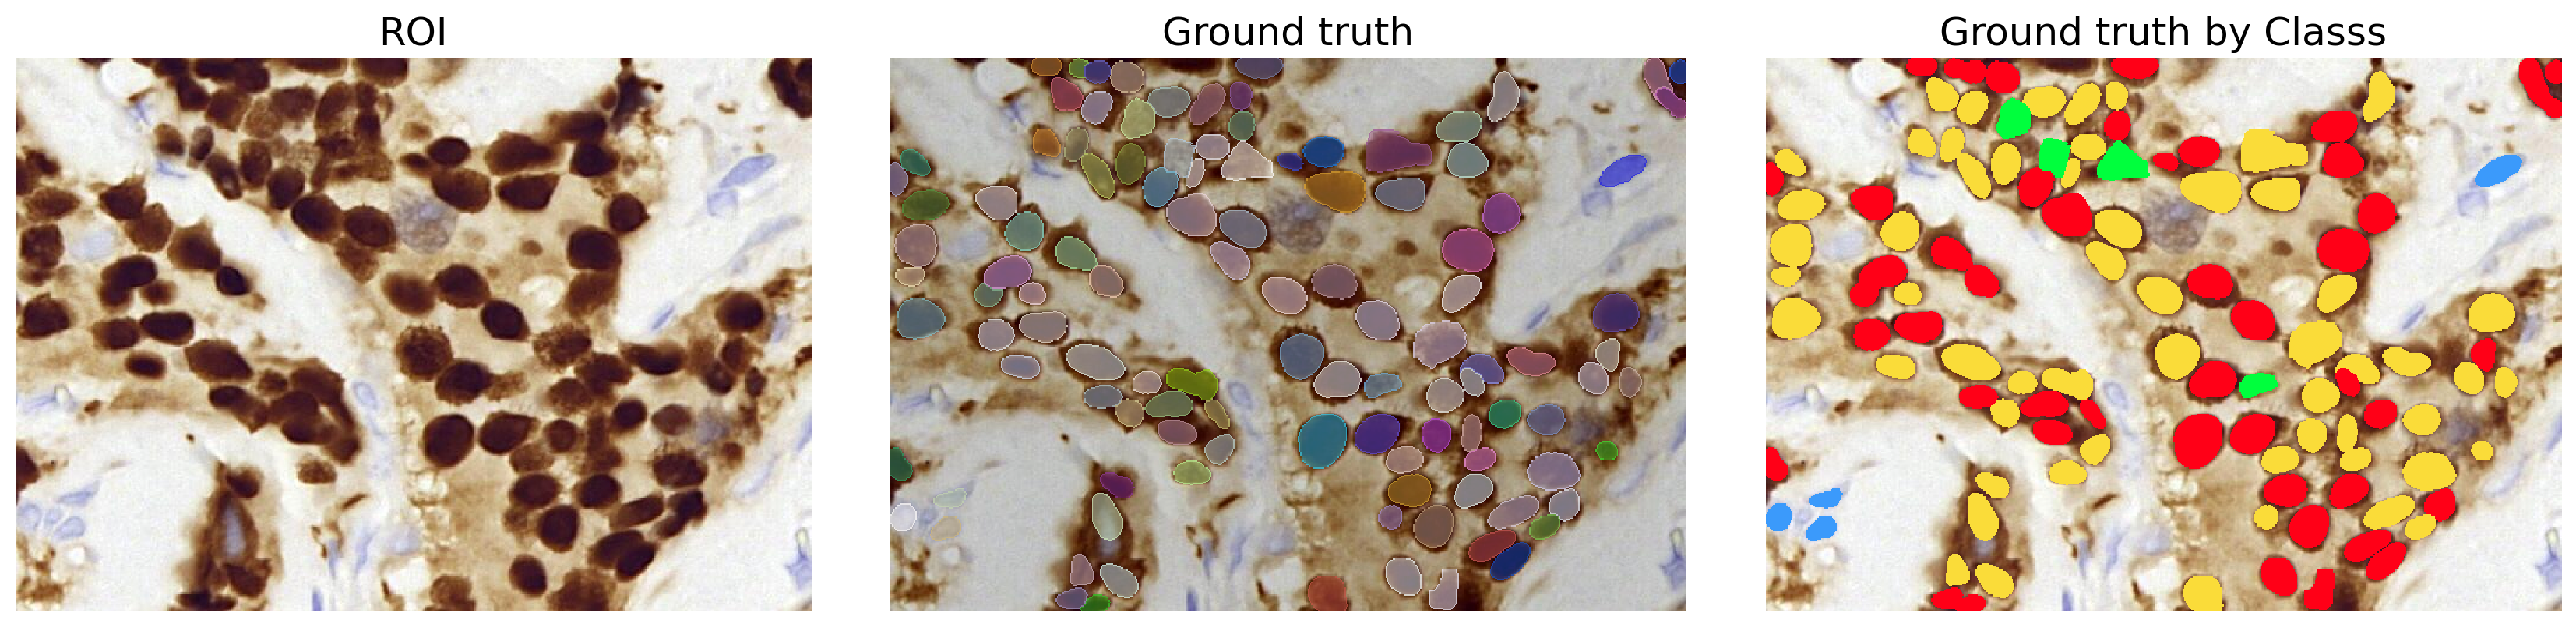

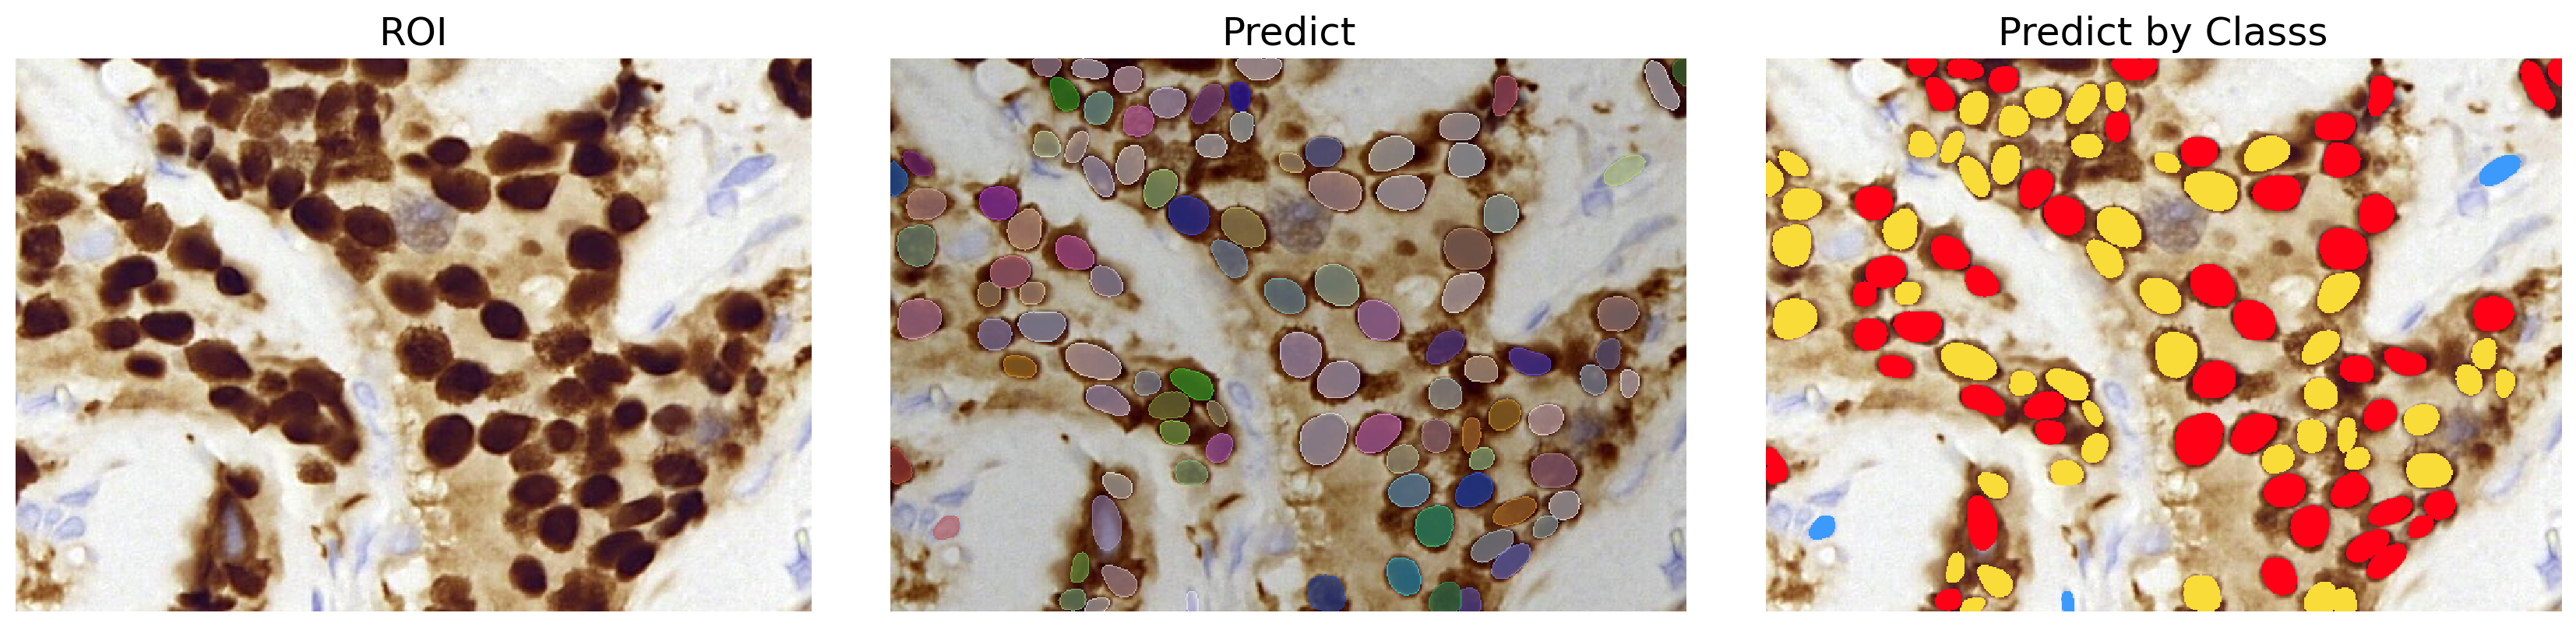

In [9]:
plot_all(X_test[i], Y_test[i], C_test[i],            lbl_title="Ground truth", cls_title="Ground truth by Classs")
plot_all(X_test[i], label,    class_from_res(res), lbl_title="Predict", cls_title="Predict by Classs")

In [10]:
Y_test_pred, res_test_pred = tuple(zip(*[model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
              for x in tqdm(X_test[:])]))


  0%|          | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step



  2%|▏         | 1/44 [00:01<01:01,  1.42s/it]

1/1 [==============================] - 0s 24ms/step



  5%|▍         | 2/44 [00:02<00:54,  1.30s/it]

1/1 [==============================] - 0s 27ms/step



  7%|▋         | 3/44 [00:03<00:53,  1.29s/it]

1/1 [==============================] - 0s 26ms/step



  9%|▉         | 4/44 [00:04<00:35,  1.14it/s]

1/1 [==============================] - 0s 22ms/step



 11%|█▏        | 5/44 [00:04<00:25,  1.51it/s]

1/1 [==============================] - 0s 26ms/step



 14%|█▎        | 6/44 [00:04<00:20,  1.89it/s]

1/1 [==============================] - 0s 23ms/step



 16%|█▌        | 7/44 [00:04<00:15,  2.34it/s]

1/1 [==============================] - 0s 23ms/step



 18%|█▊        | 8/44 [00:06<00:25,  1.43it/s]

1/1 [==============================] - 0s 21ms/step



 20%|██        | 9/44 [00:07<00:31,  1.13it/s]

1/1 [==============================] - 0s 23ms/step



 23%|██▎       | 10/44 [00:08<00:34,  1.01s/it]

1/1 [==============================] - 0s 23ms/step



 25%|██▌       | 11/44 [00:09<00:25,  1.27it/s]

1/1 [==============================] - 0s 21ms/step



 27%|██▋       | 12/44 [00:09<00:19,  1.65it/s]

1/1 [==============================] - 0s 22ms/step



 30%|██▉       | 13/44 [00:10<00:25,  1.21it/s]

1/1 [==============================] - 0s 22ms/step



 32%|███▏      | 14/44 [00:10<00:20,  1.47it/s]

1/1 [==============================] - 0s 22ms/step



 34%|███▍      | 15/44 [00:12<00:24,  1.17it/s]

1/1 [==============================] - 0s 21ms/step



 36%|███▋      | 16/44 [00:12<00:19,  1.45it/s]

1/1 [==============================] - 0s 20ms/step



 39%|███▊      | 17/44 [00:12<00:15,  1.70it/s]

1/1 [==============================] - 0s 20ms/step



 41%|████      | 18/44 [00:13<00:13,  1.91it/s]

1/1 [==============================] - 0s 21ms/step



 43%|████▎     | 19/44 [00:13<00:11,  2.27it/s]

1/1 [==============================] - 0s 22ms/step



 45%|████▌     | 20/44 [00:14<00:16,  1.43it/s]

1/1 [==============================] - 0s 21ms/step



 48%|████▊     | 21/44 [00:16<00:20,  1.14it/s]

1/1 [==============================] - 0s 22ms/step



 50%|█████     | 22/44 [00:17<00:21,  1.00it/s]

1/1 [==============================] - 0s 21ms/step



 52%|█████▏    | 23/44 [00:17<00:17,  1.22it/s]

1/1 [==============================] - 0s 24ms/step



 55%|█████▍    | 24/44 [00:19<00:19,  1.03it/s]

1/1 [==============================] - 0s 22ms/step



 57%|█████▋    | 25/44 [00:19<00:14,  1.35it/s]

1/1 [==============================] - 0s 22ms/step



 59%|█████▉    | 26/44 [00:20<00:16,  1.11it/s]

1/1 [==============================] - 0s 21ms/step



 61%|██████▏   | 27/44 [00:21<00:17,  1.04s/it]

1/1 [==============================] - 0s 21ms/step



 64%|██████▎   | 28/44 [00:23<00:17,  1.11s/it]

1/1 [==============================] - 0s 21ms/step



 66%|██████▌   | 29/44 [00:24<00:17,  1.17s/it]

1/1 [==============================] - 0s 22ms/step



 68%|██████▊   | 30/44 [00:25<00:16,  1.21s/it]

1/1 [==============================] - 0s 20ms/step



 70%|███████   | 31/44 [00:26<00:11,  1.10it/s]

1/1 [==============================] - 0s 22ms/step



 73%|███████▎  | 32/44 [00:27<00:12,  1.03s/it]

1/1 [==============================] - 0s 21ms/step



 75%|███████▌  | 33/44 [00:27<00:08,  1.27it/s]

1/1 [==============================] - 0s 20ms/step



 77%|███████▋  | 34/44 [00:27<00:06,  1.55it/s]

1/1 [==============================] - 0s 22ms/step



 80%|███████▉  | 35/44 [00:28<00:05,  1.77it/s]

1/1 [==============================] - 0s 23ms/step



 82%|████████▏ | 36/44 [00:28<00:03,  2.13it/s]

1/1 [==============================] - 0s 21ms/step



 84%|████████▍ | 37/44 [00:29<00:05,  1.36it/s]

1/1 [==============================] - 0s 22ms/step



 86%|████████▋ | 38/44 [00:31<00:05,  1.10it/s]

1/1 [==============================] - 0s 21ms/step



 89%|████████▊ | 39/44 [00:32<00:05,  1.06s/it]

1/1 [==============================] - 0s 23ms/step



 91%|█████████ | 40/44 [00:33<00:04,  1.12s/it]

1/1 [==============================] - 0s 23ms/step



 93%|█████████▎| 41/44 [00:35<00:03,  1.15s/it]

1/1 [==============================] - 0s 22ms/step



 95%|█████████▌| 42/44 [00:36<00:02,  1.20s/it]

1/1 [==============================] - 0s 21ms/step



 98%|█████████▊| 43/44 [00:36<00:00,  1.10it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 44/44 [00:37<00:00,  1.16it/s]


In [11]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_test, Y_test_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:04<00:00,  2.02it/s]


In [12]:
stats[taus.index(0.1)]

DatasetMatching(criterion='iou', thresh=0.1, fp=415, tp=3843, fn=422, precision=0.9025364020666979, recall=0.9010550996483001, accuracy=0.8211538461538461, f1=0.9017951425554382, n_true=4265, n_pred=4258, mean_true_score=0.7440224865536617, mean_matched_score=0.8257236287149017, panoptic_quality=0.7446335574683485, by_image=False)

In [ ]:
for i in range(44):
    plot_all(X_test[i],Y_test[i],      C_test[i],                        lbl_title="Ground truth", cls_title="Ground truth by Classs")
    plot_all(X_test[i],Y_test_pred[i], class_from_res(res_test_pred[i]), lbl_title="Predict", cls_title="Predict by Classs");

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_f1=[]
all_recall=[]
all_pre=[]

for i in range(44):
    true_value = []
    predic_value = []
    for key, value in C_test[i].items():
        highlighted_image = np.zeros_like(Y_test[i])  # Create an image filled with zeros
        highlighted_image[Y_test[i] == key] = 1  # Set the pixels with the specific value to the value itself



        highlighted_image_2 = highlighted_image*Y_test_pred[i]
        flattened_matrix = highlighted_image_2.flatten()
        undesired_value = 0
        filtered_values = flattened_matrix[flattened_matrix != undesired_value]
        unique_values, counts = np.unique(filtered_values, return_counts=True)
        #highlighted_image_2[np.logical_and(highlighted_image, Y_test_pred[i]) == True] = value

        if len(counts) != 0:
            max_index = np.argmax(counts)

            true_value.append(value)
            predic_value.append(class_from_res(res_test_pred[i]).get(unique_values[max_index]))
            
    # Calculate precision, recall, and F1 score
    precision = precision_score(true_value, predic_value, average='macro')
    recall = recall_score(true_value, predic_value, average='macro')
    f1 = f1_score(true_value, predic_value, average='macro')
    
    all_f1.append(f1)
    all_pre.append(precision)
    all_recall.append(recall)

    print(f"Image: {i}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n\n")

Image: 0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 1
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 2
Precision: 0.75
Recall: 0.9962686567164178
F1 Score: 0.8314606741573034


Image: 3
Precision: 1.0
Recall: 1.0
F1 Score: 1.0




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 4
Precision: 0.5
Recall: 0.4948717948717949
F1 Score: 0.49742268041237114


Image: 5
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 6
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 7
Precision: 0.8666933974873028
Recall: 0.8333333333333334
F1 Score: 0.8476154736216657




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 8
Precision: 0.5
Recall: 0.4921875
F1 Score: 0.49606299212598426




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 9
Precision: 0.5
Recall: 0.4959016393442623
F1 Score: 0.4979423868312757


Image: 10
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 11
Precision: 0.9141604010025062
Recall: 0.8781464530892449
F1 Score: 0.8910714285714285


Image: 12
Precision: 1.0
Recall: 1.0
F1 Score: 1.0




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 13
Precision: 0.5822510822510822
Recall: 0.5523944997629209
F1 Score: 0.5589225589225589


Image: 14
Precision: 0.6027777777777777
Recall: 0.5686909581646423
F1 Score: 0.5810791469872619




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 15
Precision: 0.5
Recall: 0.4880952380952381
F1 Score: 0.4939759036144578


Image: 16
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 17
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 18
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 19
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 20
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 21
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 22
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 23
Precision: 0.6644920782851818
Recall: 0.671573359073359
F1 Score: 0.6679706021811285


Image: 24
Precision: 0.8635802469135804
Recall: 0.8391414141414142
F1 Score: 0.8454740747973831




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Image: 25
Precision: 0.9381499726327313
Recall: 0.9316239316239318
F1 Score: 0.9326599326599326


Image: 26
Precision: 0.8917184265010353
Recall: 0.902330623306233
F1 Score: 0.8957854406130267




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 27
Precision: 0.49390243902439024
Recall: 0.49390243902439024
F1 Score: 0.49390243902439024


Image: 28
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 29
Precision: 0.9206349206349206
Recall: 0.9206349206349206
F1 Score: 0.9206349206349206




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 30
Precision: 0.5748945147679324
Recall: 0.47191697191697196
F1 Score: 0.5087820883999229


Image: 31
Precision: 0.8842592592592592
Recall: 0.8878431372549018
F1 Score: 0.8853923853923854


Image: 32
Precision: 0.8053921568627451
Recall: 0.7345643939393939
F1 Score: 0.7588023088023088


Image: 33
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 34
Precision: 0.9007554945054945
Recall: 0.8316696914700544
F1 Score: 0.8403508771929824


Image: 35
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 36
Precision: 0.8197377873563217
Recall: 0.7576639387679432
F1 Score: 0.7741827245709904


Image: 37
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 38
Precision: 0.74581589958159
Recall: 0.6645658263305322
F1 Score: 0.6968553459119496


Image: 39
Precision: 0.9797979797979798
Recall: 0.6
F1 Score: 0.6563573883161512


Image: 40
Precision: 0.8726190476190476
Recall: 0.7653846153846154
F1 Score: 0.7953296703296703


Image: 41
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 42
Precision:

_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [16]:
import statistics

print(f"Precision: {statistics.mean(all_pre)}")
print(f"Recall: {statistics.mean(all_recall)}")
print(f"F1 Score: {statistics.mean(all_f1)}\n\n")

Precision: 0.8488341519876292
Recall: 0.8320119741184723
F1 Score: 0.8331095204545772




In [17]:
# --------------------------Optimised for Speed
def get_fast_aji(true, pred):
    """AJI version distributed by MoNuSeg, has no permutation problem but suffered from 
    over-penalisation similar to DICE2.

    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no 
    effect on the result.

    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter

    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()

    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()

    aji_score = overall_inter / overall_union
    return aji_score


all_aji_score=[]
for m in range(44):
    aji_score = get_fast_aji(Y_test[m],Y_test_pred[m])
    all_aji_score.append(aji_score)

print(all_aji_score)
print('Total AJI: ', (sum(all_aji_score) / len(all_aji_score)))

[0.6939865103630525, 0.7148189150719595, 0.7671441605839416, 0.7306068312627007, 0.6847563955046262, 0.6115651192176274, 0.8471039893173093, 0.6175033692722371, 0.6443941848706601, 0.6974480690327685, 0.7915322851575624, 0.7494376630777074, 0.7627246943390441, 0.5326322423096617, 0.7838477058374924, 0.7427775663425942, 0.6885392799618884, 0.7620906871424046, 0.7046040651834324, 0.7858319458712671, 0.8202581477166031, 0.7689030366356442, 0.7749844082668444, 0.6958389462655291, 0.6566144200626959, 0.6049829734040261, 0.7743475493316359, 0.728055647565419, 0.6314300213757362, 0.7641225655144285, 0.7647326631701632, 0.6942194073941456, 0.6403457639649118, 0.5905450076284116, 0.7158717067998296, 0.755161555144401, 0.6747665474163057, 0.7050913812437292, 0.7634627017258246, 0.7212310927966153, 0.6477692981893585, 0.6997239811657736, 0.7681329873657152, 0.5737784489267609]
Total AJI:  0.7101753622452374
